In [25]:
import matplotlib.pyplot as plt
import qiskit_aer
import numpy as np
import scipy as sp
import networkx as nx
from scipy.optimize import minimize
from qiskit.circuit.library import IQP
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, random_hermitian
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, SamplerV2 as Sampler, Session
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo

distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


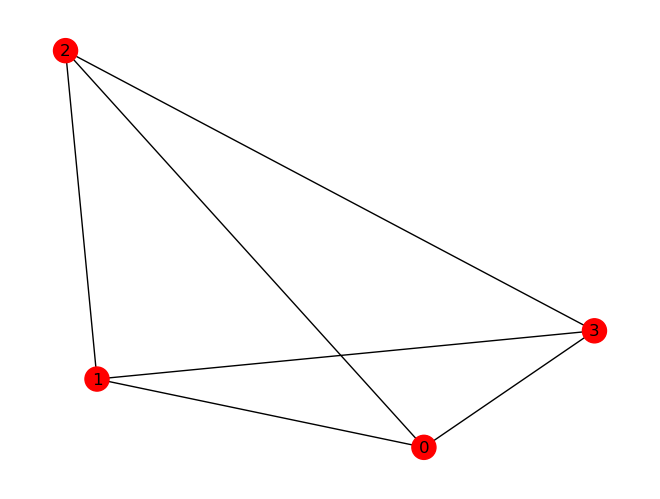

In [16]:
# Generating a graph of 3 nodes
n = 4
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
nx.draw(tsp.graph, pos, node_color = colors, with_labels = True)

In [17]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_3 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_3
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_3 + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2
  + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2 + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2
  + 48*x_0_2*x_1_1 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1 + 91*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 48*x_0_3*x_1_0 + 48*x_0_3*x_1_2
  + 91*x_0_3*x_2_0 + 91*x_0_3*x_2_2 + 33*x_0_3*x_3_0 + 33*x_0_3*x_3_2
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_3 + 71*x_1_0*x_3_1 + 71*x_1_0*x_3_3
  + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2 + 71*x_1_1*x_3_0 + 71*x_1_1*x_3_2
  + 63*x_1_2*x_2_1 + 63*x_1_2*x_2_3 + 71*x_1_2*x_3_1 + 71*x_1_2*x_3_3
  + 63*x_1_3*x_2_0 + 63*x_1_3*x_2_2 + 71*x_1_3*x_3_0 + 71*x_1_3*x_3_2
  + 92*x_2_0*x_3_1 + 92*x_2_0*x_3_3 + 92*x_2_1*x_3_0 + 92*x_2_1*x_3_2
  + 92*x_2_2*x_3_1 + 92*x_2_2*x_3_3 + 92*x_2_3*x_3_0 + 92*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

In [18]:
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 51756.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIIZIIIIIIZ', 'IIIIIIIZIIIIIIIZ', 'IIIIIIZIIIIIIIIZ', 'IIIIZIIIIIIIIIIZ', 'IIIZIIIIIIIIIIIZ', 'IIZIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIZIZI', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIZIIIIZI', 'IIIIIIIZIIIIIIZI', 'IIIIIIZIIIIIIIZI', 'IIIIIZIIIIIIIIZI', 'IIIZIIIIIIIIIIZI', 'IIZIIIIIIIIIIIZI', 'IZIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIZIIIZII', 'IIIIIIIIZIIIIZII', 'IIIIIIZIIIIIIZII', 'IIIIIZIIIIIIIZII', 'IIIIZIIIIIIIIZII', 'IIZIIIIIIIIIIZII', 'IZIIIIIII

In [19]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 236.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_0=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS


energy: -51520.00000000003
tsp objective: 235.9999999999709
feasible: True
solution: [2, 3, 0, 1]
solution objective: 236.0


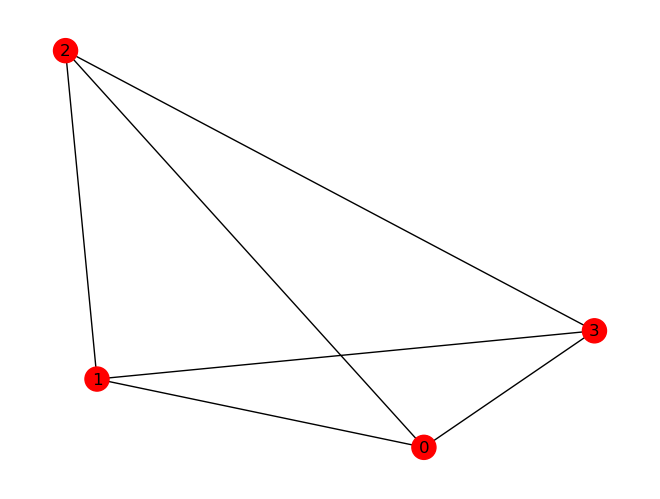

In [20]:
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
nx.draw(tsp.graph, pos, node_color = colors, with_labels = True)

In [21]:
algorithm_globals.random_seed = 123
seed = 10598

In [26]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="enter your token", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel="ibm_quantum", token="enter your token")
#backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend = qiskit_aer.Aer.get_backend('qasm_simulator')

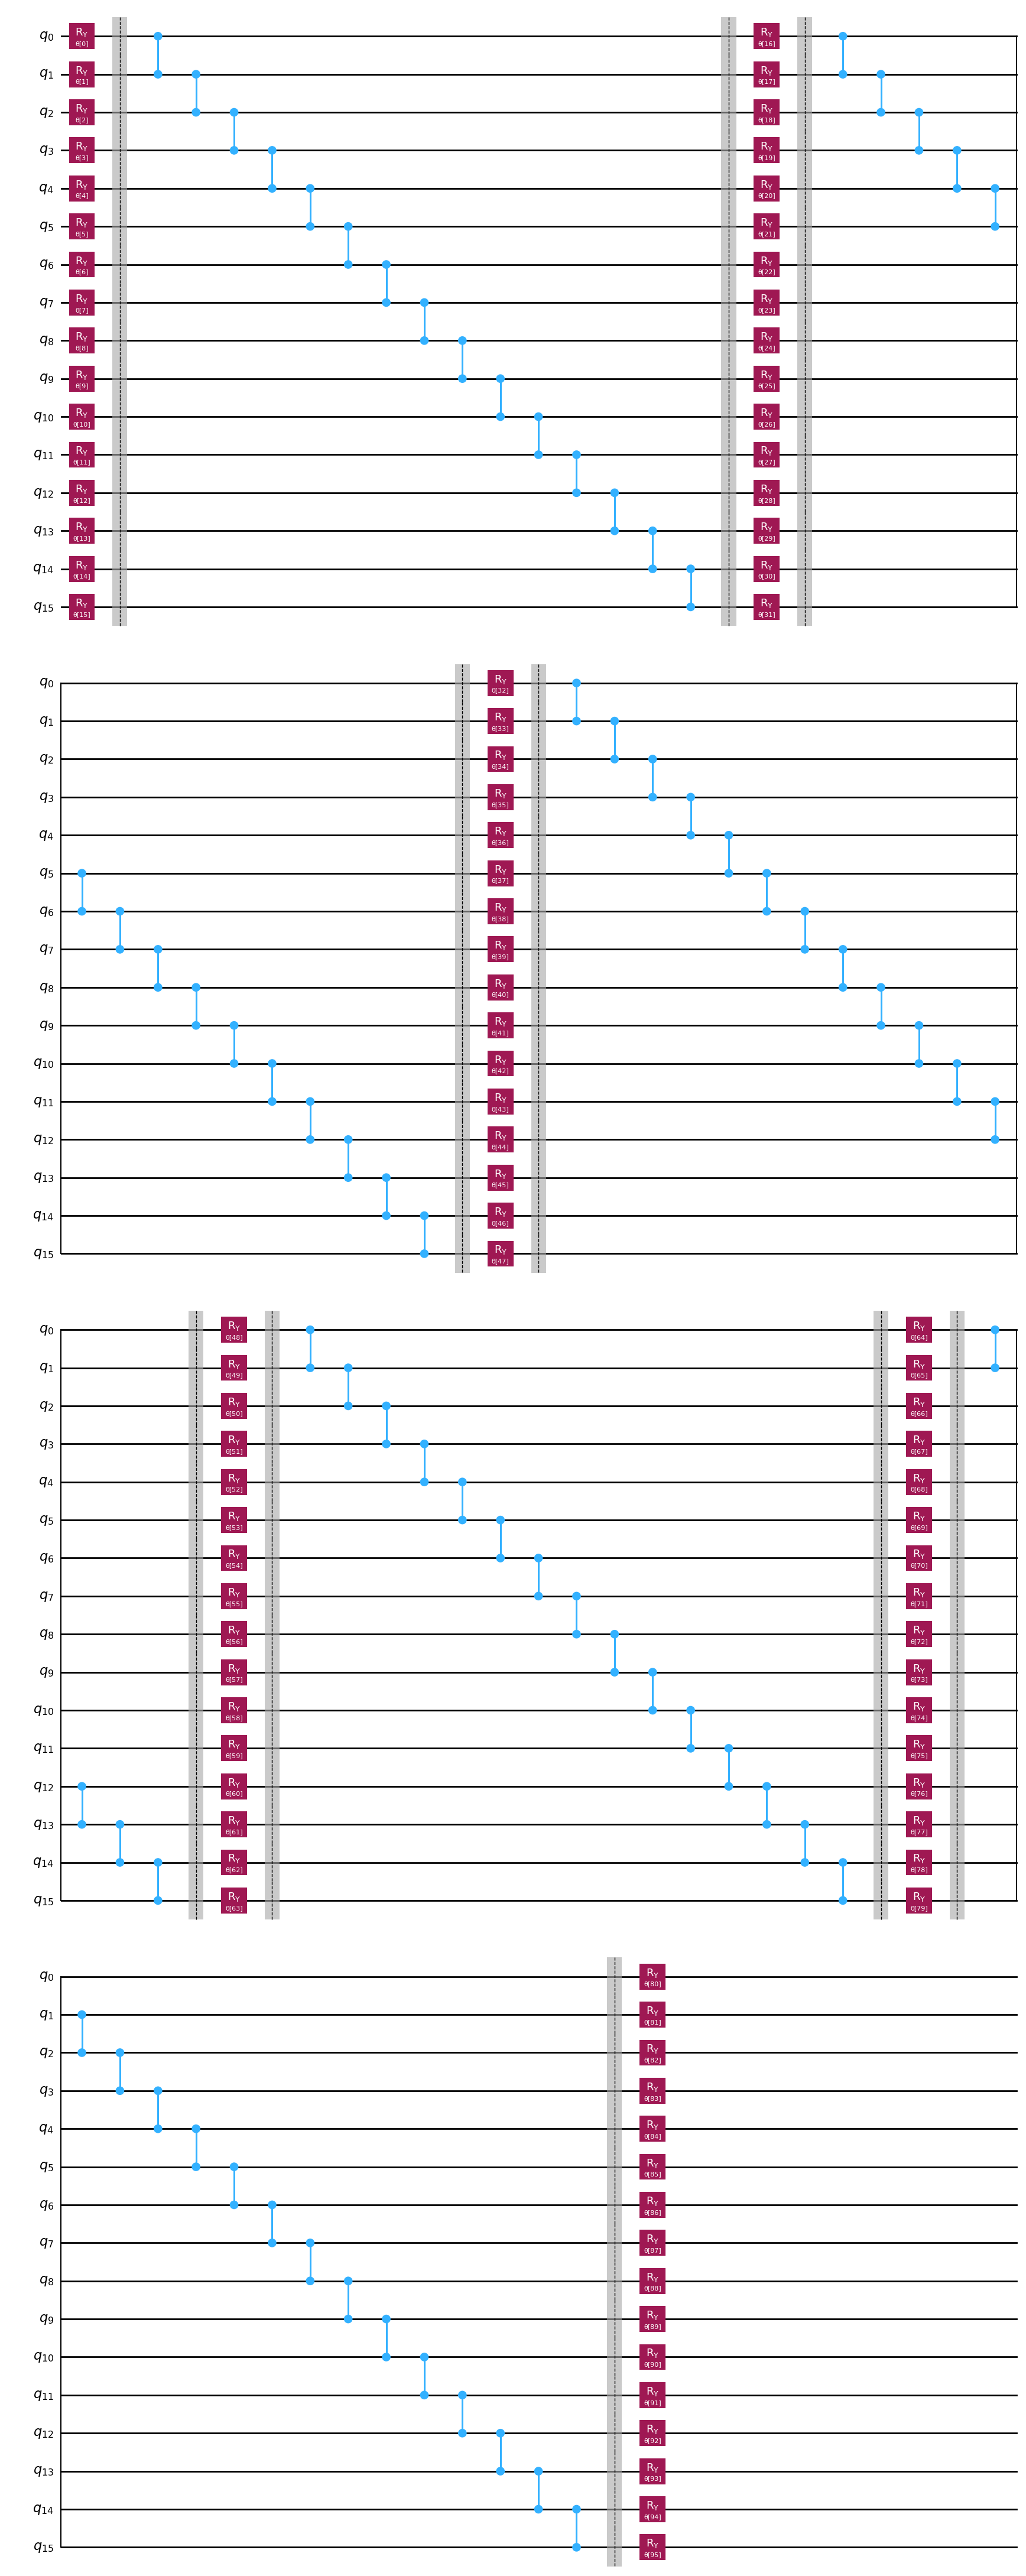

In [27]:
optimizer = SPSA(maxiter=10)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear", insert_barriers=True)
qc = QuantumCircuit(9)
qc = ry
qc.decompose().draw("mpl", style="iqp")

In [28]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(qc)

In [29]:
num_params = qc.num_parameters
num_params

96

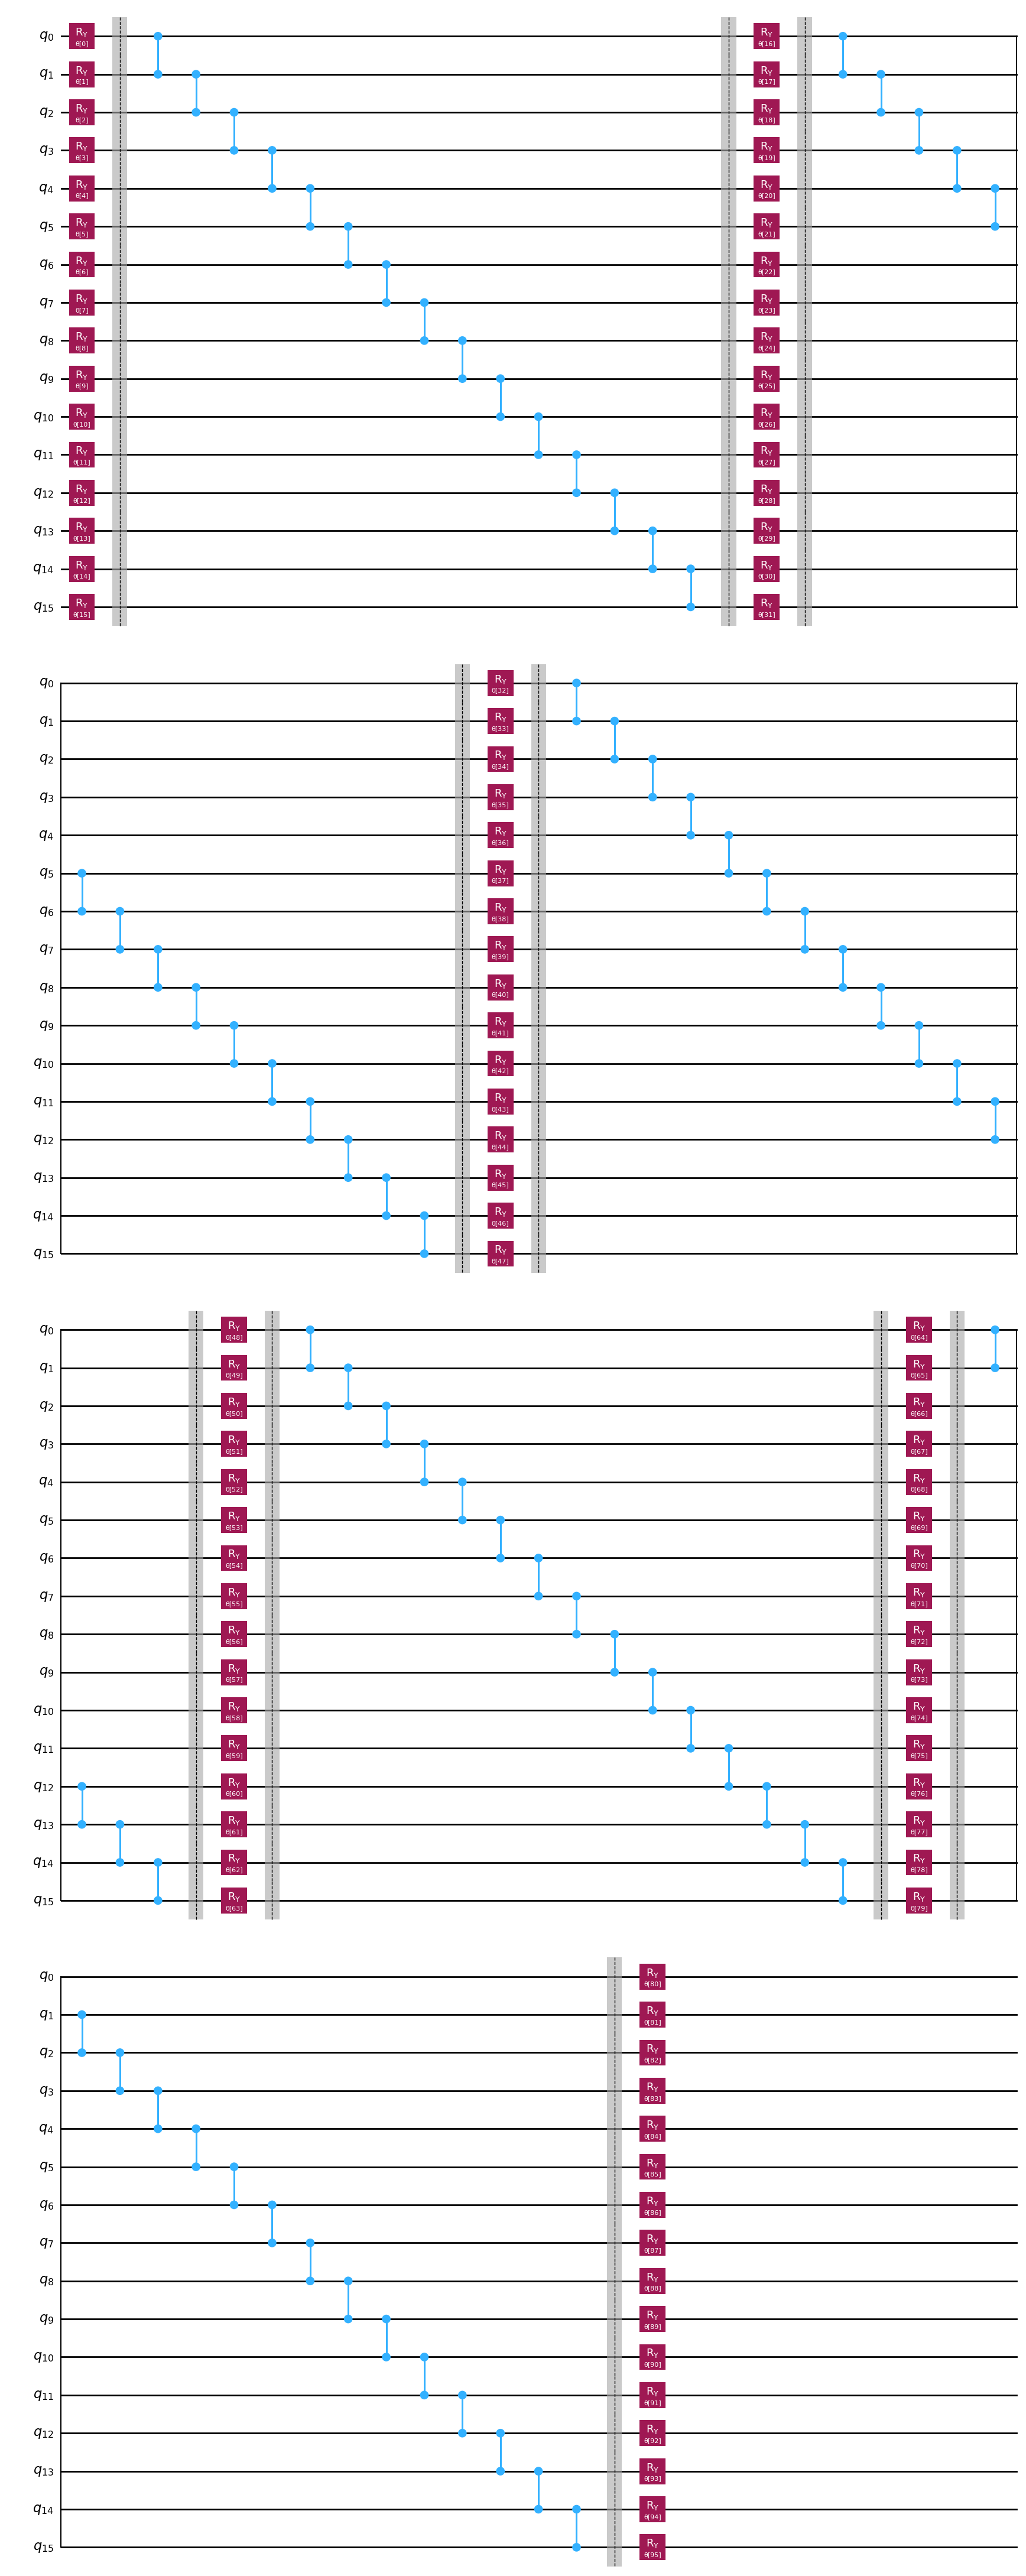

In [30]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [31]:
hamiltonian_isa = qubitOp.apply_layout(layout=ansatz_isa.layout)

In [32]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [33]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [34]:
x0 = 2 * np.pi * np.random.random(num_params)

96
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]


<BarContainer object of 96 artists>

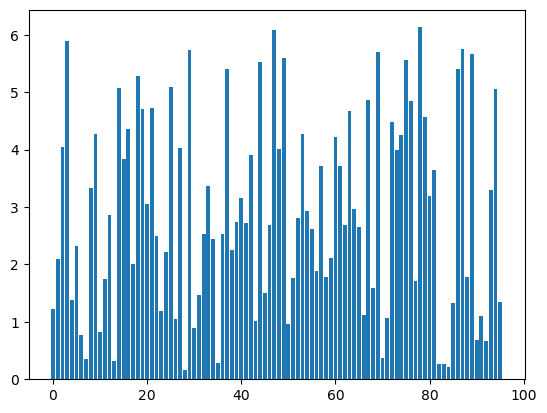

In [47]:
xdata = []
print(len(x0))
for i in range(len(x0)):
    xdata.append(i)
print(xdata)
plt.bar(xdata, x0)

In [36]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

/var/folders/1p/_qrnn68n6zx68w3m02578z200000gq/T/ipykernel_24397/1765566785.py:2: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(session=session)


Iters. done: 1 [Current cost: 6230.960400000004]
Iters. done: 2 [Current cost: 2577.2290999999987]
Iters. done: 3 [Current cost: 2984.2954999999997]
Iters. done: 4 [Current cost: 5037.266099999999]
Iters. done: 5 [Current cost: 3915.3825999999945]
Iters. done: 6 [Current cost: 1930.1547]
Iters. done: 7 [Current cost: 1443.8837000000012]
Iters. done: 8 [Current cost: -341.5141999999984]
Iters. done: 9 [Current cost: 751.3266999999992]
Iters. done: 10 [Current cost: 1501.5911000000028]
Iters. done: 11 [Current cost: 1896.2120999999975]
Iters. done: 12 [Current cost: -1286.8041000000003]
Iters. done: 13 [Current cost: -256.16499999999974]
Iters. done: 14 [Current cost: -5149.917300000002]
Iters. done: 15 [Current cost: -6096.155099999999]
Iters. done: 16 [Current cost: -8992.682900000007]
Iters. done: 17 [Current cost: -7186.8941]
Iters. done: 18 [Current cost: -4698.9371]
Iters. done: 19 [Current cost: -13001.669400000004]
Iters. done: 20 [Current cost: -14707.087099999995]
Iters. done: 

Iters. done: 162 [Current cost: -36724.51330000001]
Iters. done: 163 [Current cost: -38237.44700000001]
Iters. done: 164 [Current cost: -35516.880399999995]
Iters. done: 165 [Current cost: -37096.35669999997]
Iters. done: 166 [Current cost: -33429.23009999998]
Iters. done: 167 [Current cost: -37298.88750000001]
Iters. done: 168 [Current cost: -38540.73689999998]
Iters. done: 169 [Current cost: -38769.841399999976]
Iters. done: 170 [Current cost: -36797.42260000003]
Iters. done: 171 [Current cost: -36842.88500000001]
Iters. done: 172 [Current cost: -39193.80539999995]
Iters. done: 173 [Current cost: -37610.92300000003]
Iters. done: 174 [Current cost: -37724.31779999997]
Iters. done: 175 [Current cost: -38711.75550000001]
Iters. done: 176 [Current cost: -40269.0971]
Iters. done: 177 [Current cost: -39951.11399999997]
Iters. done: 178 [Current cost: -37263.113000000005]
Iters. done: 179 [Current cost: -39256.98979999999]
Iters. done: 180 [Current cost: -37900.74649999997]
Iters. done: 181

Iters. done: 325 [Current cost: -45785.04799999997]
Iters. done: 326 [Current cost: -44381.42560000005]
Iters. done: 327 [Current cost: -46241.32880000002]
Iters. done: 328 [Current cost: -43587.221699999995]
Iters. done: 329 [Current cost: -46348.343900000014]
Iters. done: 330 [Current cost: -45214.22120000001]
Iters. done: 331 [Current cost: -45086.59400000001]
Iters. done: 332 [Current cost: -43984.3176]
Iters. done: 333 [Current cost: -46196.15400000001]
Iters. done: 334 [Current cost: -45907.238500000014]
Iters. done: 335 [Current cost: -45768.106100000005]
Iters. done: 336 [Current cost: -46088.90880000002]
Iters. done: 337 [Current cost: -45593.17770000001]
Iters. done: 338 [Current cost: -46073.695199999995]
Iters. done: 339 [Current cost: -46072.399099999995]
Iters. done: 340 [Current cost: -46343.90810000001]
Iters. done: 341 [Current cost: -46373.374999999985]
Iters. done: 342 [Current cost: -46852.74129999997]
Iters. done: 343 [Current cost: -45147.614899999964]
Iters. done

Iters. done: 484 [Current cost: -49547.65089999999]
Iters. done: 485 [Current cost: -49194.007499999985]
Iters. done: 486 [Current cost: -49747.36010000003]
Iters. done: 487 [Current cost: -49405.396100000005]
Iters. done: 488 [Current cost: -49669.696500000035]
Iters. done: 489 [Current cost: -48645.65889999997]
Iters. done: 490 [Current cost: -49431.88209999999]
Iters. done: 491 [Current cost: -49226.95030000001]
Iters. done: 492 [Current cost: -49829.86159999999]
Iters. done: 493 [Current cost: -49546.42459999996]
Iters. done: 494 [Current cost: -49580.08859999998]
Iters. done: 495 [Current cost: -49748.26230000003]
Iters. done: 496 [Current cost: -49732.21100000005]
Iters. done: 497 [Current cost: -48837.800900000024]
Iters. done: 498 [Current cost: -49638.76759999999]
Iters. done: 499 [Current cost: -49439.623799999994]
Iters. done: 500 [Current cost: -49661.7113]
Iters. done: 501 [Current cost: -49459.59719999999]
Iters. done: 502 [Current cost: -49660.07190000004]
Iters. done: 5

Iters. done: 643 [Current cost: -50268.347699999984]
Iters. done: 644 [Current cost: -50243.14560000001]
Iters. done: 645 [Current cost: -50303.04410000003]
Iters. done: 646 [Current cost: -50228.02390000001]
Iters. done: 647 [Current cost: -50335.67460000001]
Iters. done: 648 [Current cost: -49984.25170000002]
Iters. done: 649 [Current cost: -50280.531799999975]
Iters. done: 650 [Current cost: -50179.55429999999]
Iters. done: 651 [Current cost: -50346.07590000001]
Iters. done: 652 [Current cost: -50355.17749999997]
Iters. done: 653 [Current cost: -50312.0274]
Iters. done: 654 [Current cost: -50489.71400000001]
Iters. done: 655 [Current cost: -50490.24050000006]
Iters. done: 656 [Current cost: -50177.37910000001]
Iters. done: 657 [Current cost: -50410.557299999986]
Iters. done: 658 [Current cost: -50528.611499999985]
Iters. done: 659 [Current cost: -50462.869200000016]
Iters. done: 660 [Current cost: -50515.5798]
Iters. done: 661 [Current cost: -50489.034799999994]
Iters. done: 662 [Cu

Iters. done: 803 [Current cost: -50577.4955]
Iters. done: 804 [Current cost: -50550.267300000014]
Iters. done: 805 [Current cost: -50475.659099999975]
Iters. done: 806 [Current cost: -50487.29589999997]
Iters. done: 807 [Current cost: -50544.615200000044]
Iters. done: 808 [Current cost: -50548.33389999998]
Iters. done: 809 [Current cost: -50509.41410000001]
Iters. done: 810 [Current cost: -50555.949499999995]
Iters. done: 811 [Current cost: -50559.686299999965]
Iters. done: 812 [Current cost: -50493.87039999998]
Iters. done: 813 [Current cost: -50569.4847]
Iters. done: 814 [Current cost: -50558.499099999986]
Iters. done: 815 [Current cost: -50476.89910000002]
Iters. done: 816 [Current cost: -50557.934599999986]
Iters. done: 817 [Current cost: -50474.423000000024]
Iters. done: 818 [Current cost: -50548.168]
Iters. done: 819 [Current cost: -50514.47539999995]
Iters. done: 820 [Current cost: -50610.64089999996]
Iters. done: 821 [Current cost: -50527.327099999995]
Iters. done: 822 [Current

Iters. done: 966 [Current cost: -50506.8039]
Iters. done: 967 [Current cost: -50519.14339999998]
Iters. done: 968 [Current cost: -50552.03339999998]
Iters. done: 969 [Current cost: -50550.82700000001]
Iters. done: 970 [Current cost: -50500.864500000025]
Iters. done: 971 [Current cost: -50450.984199999984]
Iters. done: 972 [Current cost: -50503.7869]
Iters. done: 973 [Current cost: -50569.29230000003]
Iters. done: 974 [Current cost: -50513.54810000004]
Iters. done: 975 [Current cost: -50503.4232]
Iters. done: 976 [Current cost: -50507.34479999999]
Iters. done: 977 [Current cost: -50593.1024]
Iters. done: 978 [Current cost: -50456.53599999999]
Iters. done: 979 [Current cost: -50533.25220000001]
Iters. done: 980 [Current cost: -50501.278799999985]
Iters. done: 981 [Current cost: -50511.355399999986]
Iters. done: 982 [Current cost: -50568.17200000002]
Iters. done: 983 [Current cost: -50531.25399999998]
Iters. done: 984 [Current cost: -50529.69299999998]
Iters. done: 985 [Current cost: -505

In [37]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -50636.796800000004
       x: [ 2.081e+00  2.758e+00 ...  4.354e+00  1.253e+00]
    nfev: 1000
   maxcv: 0.0

<BarContainer object of 96 artists>

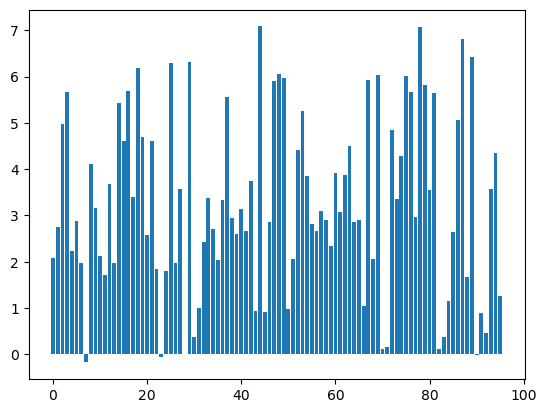

In [48]:
plt.bar(xdata, res.x)

In [38]:
all(cost_history_dict["prev_vector"] == res.x)

False

In [39]:
cost_history_dict["iters"] == res.nfev

True

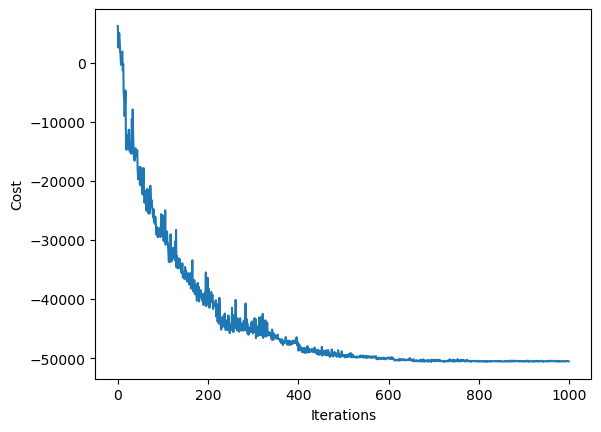

In [40]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()